<a href="https://colab.research.google.com/github/richa11101982/-git-clone-https-github.com-android-codelab-android-kmp/blob/main/Physics_driven_ML_for_device_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

def physics_informed_loss(model, x_input, epsilon, charge_density):
    """
    x_input: spatial coordinates (e.g., depth through the layers)
    epsilon: permittivity of the specific layer at x
    charge_density: fixed background charge (dopants)
    """
    x_input.requires_grad = True

    # 1. Forward pass: Predict Electrical Potential (phi)
    phi = model(x_input)

    # 2. Compute first derivative (Electric Field E = -d_phi/dx)
    d_phi_dx = torch.autograd.grad(phi, x_input, torch.ones_like(phi), create_graph=True)[0]

    # 3. Compute second derivative (Laplacian)
    d2_phi_dx2 = torch.autograd.grad(d_phi_dx, x_input, torch.ones_like(d_phi_dx), create_graph=True)[0]

    # 4. Define the Poisson Residual: (epsilon * d2_phi/dx2) + total_charge
    # In a perfect physical world, this 'residual' should be zero.
    poisson_residual = (epsilon * d2_phi_dx2) + charge_density

    # 5. Physics Loss is the Mean Squared Error of the residual
    loss_physics = torch.mean(poisson_residual**2)

    return loss_physics

In [7]:
import torch
import torch.nn as nn

# Define a simple Neural Network for predicting electrical potential
class PhysicsInformedNet(nn.Module):
    def __init__(self):
        super(PhysicsInformedNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),  # Input layer: 1 input feature (x_input) -> 64 neurons
            nn.Tanh(),         # Activation function (Tanh is common in PINNs)
            nn.Linear(64, 64), # Hidden layer: 64 neurons -> 64 neurons
            nn.Tanh(),         # Activation function
            nn.Linear(64, 1)   # Output layer: 64 neurons -> 1 output feature (phi)
        )

    def forward(self, x):
        return self.net(x)

print('PhysicsInformedNet class defined. This can be used with physics_informed_loss.')

PhysicsInformedNet class defined. This can be used with physics_informed_loss.


This `PhysicsInformedNet` is a typical architecture for PINNs:

*   It takes a single input (`x_input`, the spatial coordinate) and outputs a single value (`phi`, the electrical potential).
*   It uses `nn.Linear` layers for the network's structure.
*   `Tanh` activation functions are chosen for their smoothness, which is beneficial when computing derivatives (as required by the `physics_informed_loss`).

This network structure allows the model to learn a complex, non-linear mapping from spatial coordinates to the electrical potential while ensuring that its derivatives can be smoothly calculated.

In [6]:
import torch

# 1. Generate x_input (spatial coordinates)
# Let's say we are interested in a domain from 0 to 10
x_start = 0.0
x_end = 10.0
num_points = 100
x_input = torch.linspace(x_start, x_end, num_points).view(-1, 1)

print(f"x_input shape: {x_input.shape}")
print(f"x_input sample (first 5):\n{x_input[:5]}")

# 2. Generate epsilon (permittivity)
# For a simple case, let's assume a constant permittivity
epsilon_value = 8.854e-12  # Permittivity of free space (a common physical constant)
epsilon = torch.full_like(x_input, epsilon_value)

print(f"\nepsilon shape: {epsilon.shape}")
print(f"epsilon sample (first 5):\n{epsilon[:5]}")

# 3. Generate charge_density (fixed background charge)
# For a simple case, let's assume a constant charge density
charge_density_value = 1.602e-19 * 1e18 # Example: elementary charge * doping concentration (e.g., 1e18 cm^-3)
charge_density = torch.full_like(x_input, charge_density_value)

print(f"\ncharge_density shape: {charge_density.shape}")
print(f"charge_density sample (first 5):\n{charge_density[:5]}")

x_input shape: torch.Size([100, 1])
x_input sample (first 5):
tensor([[0.0000],
        [0.1010],
        [0.2020],
        [0.3030],
        [0.4040]])

epsilon shape: torch.Size([100, 1])
epsilon sample (first 5):
tensor([[8.8540e-12],
        [8.8540e-12],
        [8.8540e-12],
        [8.8540e-12],
        [8.8540e-12]])

charge_density shape: torch.Size([100, 1])
charge_density sample (first 5):
tensor([[0.1602],
        [0.1602],
        [0.1602],
        [0.1602],
        [0.1602]])


In this example:

*   `x_input` is created using `torch.linspace` to generate 100 evenly spaced points between 0 and 10, reshaped to `(100, 1)` to match the expected input format of a neural network.
*   `epsilon` and `charge_density` are created using `torch.full_like`, which creates a tensor of the same size as `x_input` and fills it with a specified constant value. This ensures they have the correct shape for element-wise operations within the `physics_informed_loss` function.

You can adjust the ranges, number of points, and specific values for `epsilon_value` and `charge_density_value` based on the specific physical problem you are trying to model.

In [5]:
model = PotentialNet()
print('PotentialNet model instantiated:')
print(model)

PotentialNet model instantiated:
PotentialNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [4]:
import torch
import torch.nn as nn

# Define a simple Neural Network for predicting electrical potential
class PotentialNet(nn.Module):
    def __init__(self):
        super(PotentialNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),  # Input layer: 1 input feature (x_input) -> 64 neurons
            nn.Tanh(),         # Activation function (Tanh is common in PINNs)
            nn.Linear(64, 64), # Hidden layer: 64 neurons -> 64 neurons
            nn.Tanh(),         # Activation function
            nn.Linear(64, 1)   # Output layer: 64 neurons -> 1 output feature (phi)
        )

    def forward(self, x):
        return self.net(x)

print('PotentialNet class defined.')

# Example of how to instantiate the model
# model = PotentialNet()
# print(model)


PotentialNet class defined.


In this `PotentialNet` example:

*   The `__init__` method defines the layers of the neural network using `nn.Sequential`.
*   The first `nn.Linear(1, 64)` layer takes the single spatial coordinate as input and maps it to 64 neurons.
*   Two hidden layers with `nn.Linear(64, 64)` are used, each followed by a `nn.Tanh()` activation function. Tanh is often preferred over ReLU in PINNs because it's smooth and its derivatives don't become zero as easily, which is beneficial when computing higher-order derivatives.
*   The final `nn.Linear(64, 1)` layer outputs the single predicted electrical potential `phi`.
*   The `forward` method simply passes the input `x` through the defined sequence of layers.

You would then instantiate this `PotentialNet` and pass it to your `physics_informed_loss` function, along with your spatial inputs, permittivity, and charge density.

Epoch [10/100], Loss: 223.8230
Epoch [20/100], Loss: 138.4350
Epoch [30/100], Loss: 86.3136
Epoch [40/100], Loss: 54.4984
Epoch [50/100], Loss: 35.0781
Epoch [60/100], Loss: 23.2239
Epoch [70/100], Loss: 15.9879
Epoch [80/100], Loss: 11.5711
Epoch [90/100], Loss: 8.8750
Epoch [100/100], Loss: 7.2293

Training complete!


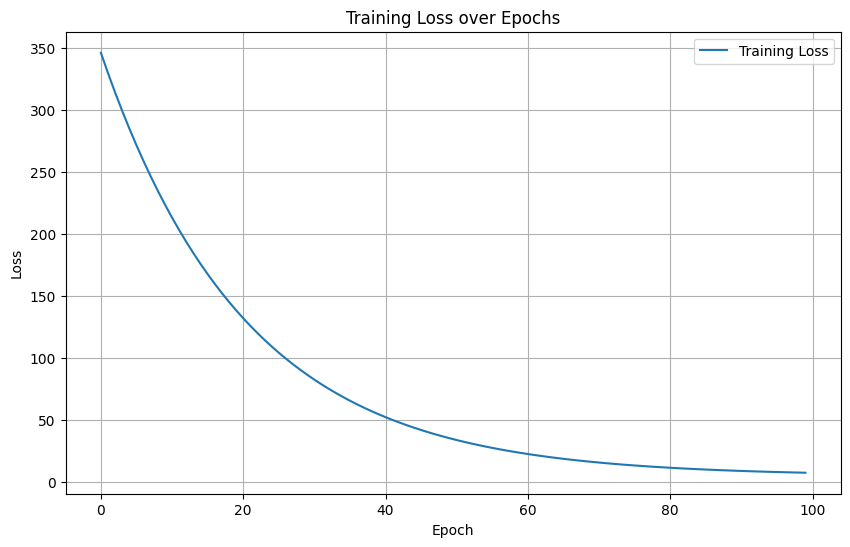

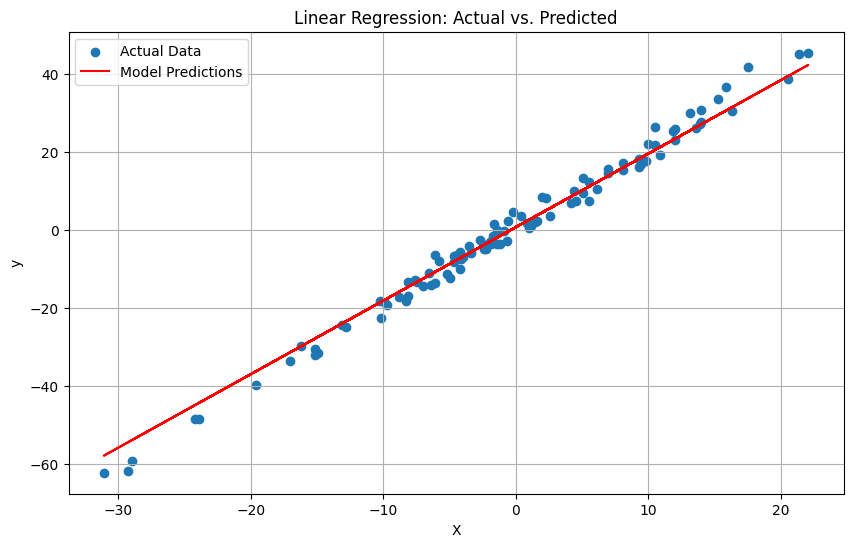


Model parameters:
linear.weight: [[1.8833336]]
linear.bias: [0.7287609]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1. Define a simple Linear Regression Model
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(1, 1) # One input feature, one output feature

    def forward(self, x):
        return self.linear(x)

# 2. Generate some synthetic data
# We want to model y = 2x + 1 + noise
X = torch.randn(100, 1) * 10 # 100 data points, 1 feature
y = 2 * X + 1 + torch.randn(100, 1) * 2 # y = 2x + 1 + some noise

# 3. Instantiate the model, loss function, and optimizer
model = LinearRegression()
criterion = nn.MSELoss() # Mean Squared Error Loss
optimizer = optim.SGD(model.parameters(), lr=0.0001) # Stochastic Gradient Descent with a reduced learning rate

# 4. Training loop
num_epochs = 100
losses = []

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward and optimize
    optimizer.zero_grad() # Clear gradients
    loss.backward() # Compute gradients
    optimizer.step() # Update weights

    losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('\nTraining complete!')

# 5. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()
plt.show()

# 6. Visualize the model's predictions vs. actual data
predicted_values = model(X).detach().numpy()

plt.figure(figsize=(10, 6))
plt.scatter(X.numpy(), y.numpy(), label='Actual Data')
plt.plot(X.numpy(), predicted_values, color='red', label='Model Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression: Actual vs. Predicted')
plt.grid(True)
plt.legend()
plt.show()

print('\nModel parameters:')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'{name}: {param.data.numpy()}')